Detecting Skin By Using Chromacity Values with Mean and Covariance

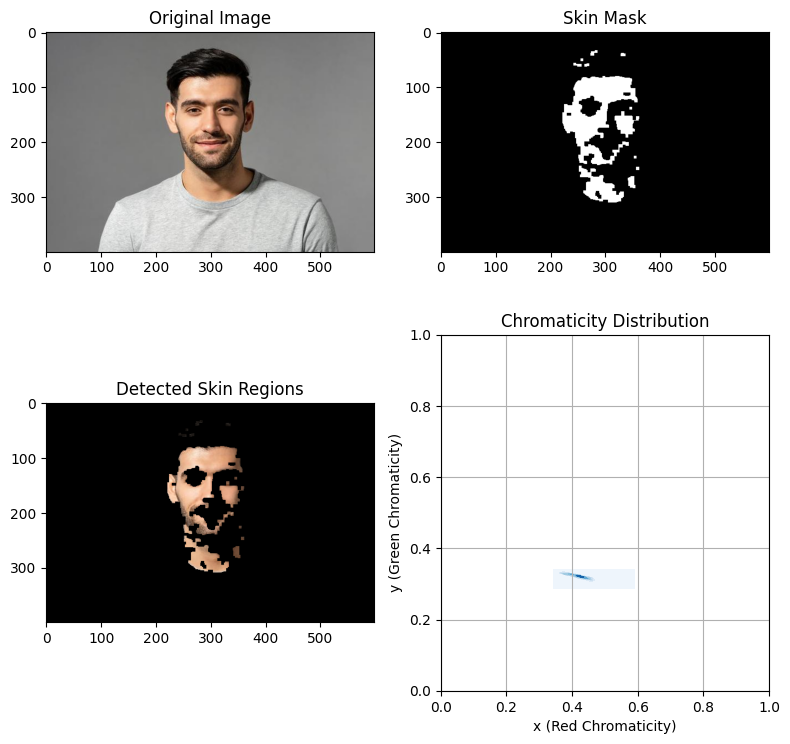

In [18]:
# Calculate color chromaticity -  mean and covariance

import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def calculate_xy_chromaticity(image):
    # Convert to float32 and normalize
    image = image.astype(np.float32) / 255.0

    # Calculate sum of RGB values
    sum_rgb = np.sum(image, axis=2)
    sum_rgb[sum_rgb == 0] = 1e-10

    # Calculate chromaticity values
    x = image[:, :, 2] / sum_rgb  # Red chromaticity
    y = image[:, :, 1] / sum_rgb  # Green chromaticity

    return x, y

def select_skin_roi(image):
    roi = cv2.selectROI("Select Skin Area", image)
    cv2.destroyAllWindows()
    return image[int(roi[1]):int(roi[1]+roi[3]),
                int(roi[0]):int(roi[0]+roi[2])]

def compute_skin_statistics(skin_roi):
    """
    Compute mean and covariance of skin chromaticity values.
    """
    roi_x, roi_y = calculate_xy_chromaticity(skin_roi)

    mean_x = np.mean(roi_x)
    mean_y = np.mean(roi_y)

    xy_points = np.column_stack((roi_x.flatten(), roi_y.flatten()))
    covariance = np.cov(xy_points.T)

    return mean_x, mean_y, covariance, xy_points  # Updated return value


def detect_skin_regions(image, mean_x, mean_y, covariance, threshold=2.5):
    # Get chromaticity values for entire image
    img_x, img_y = calculate_xy_chromaticity(image)
    height, width = img_x.shape

    # Reshape image points
    xy_points = np.column_stack((img_x.flatten(), img_y.flatten()))
    mean = np.array([mean_x, mean_y])

    # Calculate Mahalanobis distance for each pixel
    inv_covariance = np.linalg.inv(covariance)
    diff = xy_points - mean
    mahalanobis_dist = np.sqrt(np.sum(np.dot(diff, inv_covariance) * diff, axis=1))

    # Create skin mask based on Mahalanobis distance
    skin_mask = (mahalanobis_dist < threshold).astype(np.uint8)
    skin_mask = skin_mask.reshape(height, width)

    return skin_mask, mahalanobis_dist.reshape(height, width)

def process_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not load image")

    # Select skin ROI
    skin_roi = select_skin_roi(image)

    # Compute skin statistics
    mean_x, mean_y, covariance, xy_points = compute_skin_statistics(skin_roi)

    # Detect skin regions
    skin_mask, distance_map = detect_skin_regions(image, mean_x, mean_y, covariance)

    # Clean up mask
    kernel = np.ones((5,5), np.uint8)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)

    # Apply mask to original image
    final_output = cv2.bitwise_and(image, image, mask=skin_mask)

    # Normalize distance map for visualization
    distance_map_norm = (distance_map - distance_map.min()) / (distance_map.max() - distance_map.min())

    # Display results
    plt.figure(figsize=(8, 8))

    plt.subplot(221)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(222)
    plt.title('Skin Mask')
    plt.imshow(skin_mask, cmap='gray')

    plt.subplot(223)
    plt.title('Detected Skin Regions')
    plt.imshow(cv2.cvtColor(final_output, cv2.COLOR_BGR2RGB))

    # New Chromaticity Distribution Plot
    # plt.subplot(224)
    # plt.title('Chromaticity Distribution')
    # plt.scatter(xy_points[:, 0], xy_points[:, 1], color='blue', alpha=0.5, s=1)
    # plt.xlabel('x (Red Chromaticity)')
    # plt.ylabel('y (Green Chromaticity)')
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    # plt.grid(True)

    # Replace scatter plot with KDE contour plot
    plt.subplot(224)
    plt.title('Chromaticity Distribution')

    # Use seaborn kdeplot with correct syntax
    sns.kdeplot(x=xy_points[:, 0], y=xy_points[:, 1], cmap="Blues", fill=True, thresh=0)

    plt.xlabel('x (Red Chromaticity)')
    plt.ylabel('y (Green Chromaticity)')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    image_path = "Images/Man.jpg"  # Replace with your image path
    process_image(image_path)

Test for Several Images

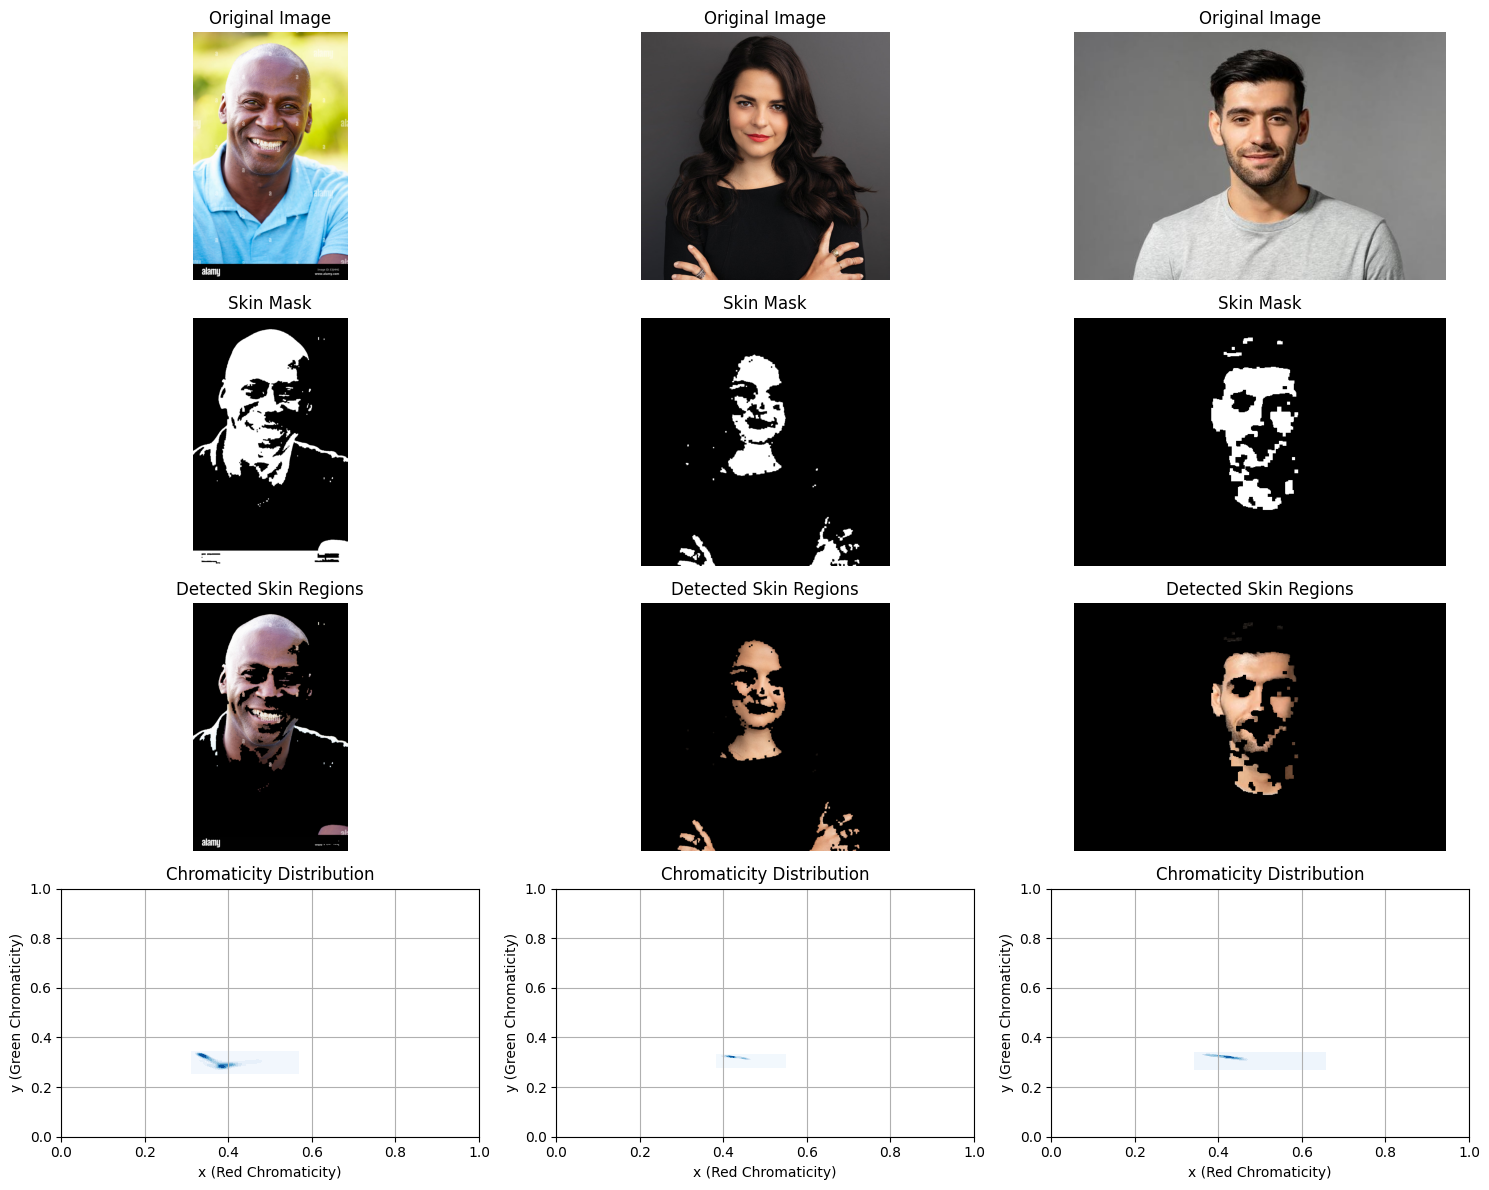

In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def calculate_xy_chromaticity(image):
    image = image.astype(np.float32) / 255.0
    sum_rgb = np.sum(image, axis=2)
    sum_rgb[sum_rgb == 0] = 1e-10
    x = image[:, :, 2] / sum_rgb  # Red chromaticity
    y = image[:, :, 1] / sum_rgb  # Green chromaticity
    return x, y

def select_skin_roi(image):
    roi = cv2.selectROI("Select Skin Area", image)
    cv2.destroyAllWindows()
    return image[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]

def compute_skin_statistics(skin_roi):
    roi_x, roi_y = calculate_xy_chromaticity(skin_roi)
    mean_x = np.mean(roi_x)
    mean_y = np.mean(roi_y)
    xy_points = np.column_stack((roi_x.flatten(), roi_y.flatten()))
    covariance = np.cov(xy_points.T)
    return mean_x, mean_y, covariance, xy_points

def detect_skin_regions(image, mean_x, mean_y, covariance, threshold=2.5):
    img_x, img_y = calculate_xy_chromaticity(image)
    height, width = img_x.shape
    xy_points = np.column_stack((img_x.flatten(), img_y.flatten()))
    mean = np.array([mean_x, mean_y])
    inv_covariance = np.linalg.inv(covariance)
    diff = xy_points - mean
    mahalanobis_dist = np.sqrt(np.sum(np.dot(diff, inv_covariance) * diff, axis=1))
    skin_mask = (mahalanobis_dist < threshold).astype(np.uint8)
    skin_mask = skin_mask.reshape(height, width)
    return skin_mask, mahalanobis_dist.reshape(height, width)

def process_image(image_path, subplot_index):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not load image")
    skin_roi = select_skin_roi(image)
    mean_x, mean_y, covariance, xy_points = compute_skin_statistics(skin_roi)
    skin_mask, distance_map = detect_skin_regions(image, mean_x, mean_y, covariance)
    kernel = np.ones((5,5), np.uint8)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)
    final_output = cv2.bitwise_and(image, image, mask=skin_mask)
    plt.subplot(4, 3, subplot_index)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(4, 3, subplot_index + 3)
    plt.title('Skin Mask')
    plt.imshow(skin_mask, cmap='gray')
    plt.axis('off')
    plt.subplot(4, 3, subplot_index + 6)
    plt.title('Detected Skin Regions')
    plt.imshow(cv2.cvtColor(final_output, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(4, 3, subplot_index + 9)
    plt.title('Chromaticity Distribution')
    sns.kdeplot(x=xy_points[:, 0], y=xy_points[:, 1], cmap="Blues", fill=True, thresh=0)
    plt.xlabel('x (Red Chromaticity)')
    plt.ylabel('y (Green Chromaticity)')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)

def main():
    image_paths = ["Images/Man1.jpg", "Images/Women.jpg", "Images/Man.jpg"]  # Replace with actual paths
    plt.figure(figsize=(15, 12))
    for i, image_path in enumerate(image_paths):
        process_image(image_path, i + 1)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Final Evaluation for Above 3 Images

C:\Users\thara\AppData\Local\Temp\ipykernel_13788\200536845.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


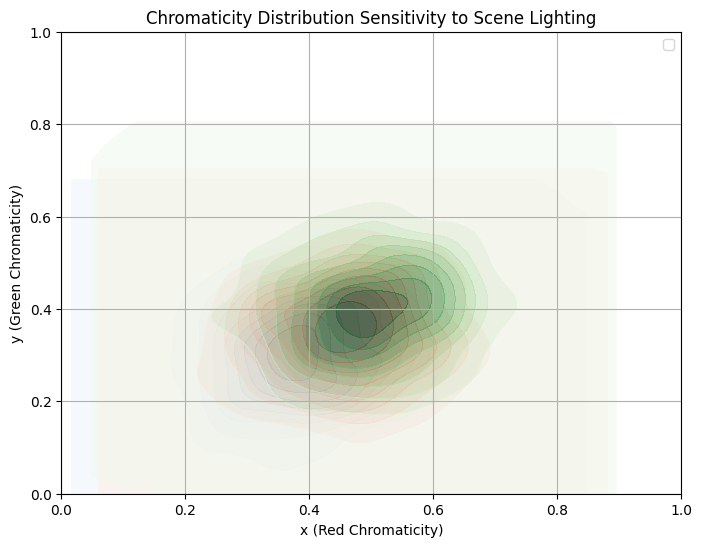

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_chromaticity(distributions):
    """
    Plot a combined chromaticity distribution from multiple images to analyze sensitivity to color balance.
    :param distributions: List of chromaticity data points from different images.
    """
    plt.figure(figsize=(8, 6))
    
    colors = ["Blues", "Reds", "Greens"]  # Different colors for each distribution
    labels = ["Image 1", "Image 2", "Image 3"]
    
    for i, (xy_points, color, label) in enumerate(zip(distributions, colors, labels)):
        sns.kdeplot(x=xy_points[:, 0], y=xy_points[:, 1], cmap=color, fill=True, thresh=0, alpha=0.5, label=label)
    
    plt.xlabel('x (Red Chromaticity)')
    plt.ylabel('y (Green Chromaticity)')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.title('Chromaticity Distribution Sensitivity to Scene Lighting')
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming we have collected chromaticity data from three images
# Each entry in `distributions` should be a numpy array of shape (N,2) where N is the number of skin pixels

# Dummy data for illustration purposes
distributions = [
    np.random.multivariate_normal([0.4, 0.3], [[0.01, 0], [0, 0.01]], 500),
    np.random.multivariate_normal([0.45, 0.35], [[0.01, 0], [0, 0.01]], 500),
    np.random.multivariate_normal([0.5, 0.4], [[0.01, 0], [0, 0.01]], 500)
]

plot_combined_chromaticity(distributions)


#### Conclusion

If the chromaticity distributions under different lighting conditions are compact and overlapping, then a simple color ratio may work well. However, if they shift significantly, then the full chromaticity-based approach (using mean & covariance) is likely necessary for better accuracy.